In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import CSVLogger
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import r2_score
import pickle

In [ ]:
def split_sequence(dataset, n_steps=1):
  X, y = list(), list()
  for i in range(len(dataset) - n_steps - 1):
    seq_X = dataset[i:(i + n_steps), :]
    X.append(seq_X)
    y.append(dataset[i + n_steps, -1])
  return np.array(X), np.array(y)

In [ ]:
def split_multi_sequence(dataset, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(dataset) - n_steps_in - n_steps_out):
    seq_X = dataset[i:(i + n_steps_in), :]
    X.append(seq_X)
    seq_y = dataset[(i + n_steps_in):(i + n_steps_in + n_steps_out), -1]
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
def create_LSTM_model(n_steps, n_features):
  model = Sequential()
  model.add(LSTM(30, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(LSTM(30, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
def create_multi_step_LSTM_model(n_steps_in, n_steps_out, n_features):
  model = Sequential()
  model.add(LSTM(60, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(LSTM(60, activation='relu'))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
def create_GRU_model(n_steps, n_features):
  model = Sequential()
  model.add(GRU(30, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(GRU(30, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
def create_multi_step_GRU_model(n_steps_in, n_steps_out, n_features):
  model = Sequential()
  model.add(GRU(60, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(GRU(60, activation='relu'))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
def retransform_data(scaler, data):
  data = scaler.inverse_transform(data)
  data = np.exp(data) - 1
  return data

In [ ]:
df_train = pd.read_csv('./preprocessed_datasets/Karpos/train.csv', index_col=0)
df_validation = pd.read_csv('./preprocessed_datasets/Karpos/validation.csv', index_col=0)
df_test = pd.read_csv('./preprocessed_datasets/Karpos/test.csv', index_col=0)

In [ ]:
df_train_PM10 = df_train.copy()
df_validation_PM10 = df_validation.copy()
df_test_PM10 = df_test.copy()
df_train_PM10.drop(['PM25', 'SO2'], axis=1, inplace=True)
df_validation_PM10.drop(['PM25', 'SO2'], axis=1, inplace=True)
df_test_PM10.drop(['PM25', 'SO2'], axis=1, inplace=True)

# 24 steps for 24 hours (1 day)
num_of_steps = 24
num_of_features = len(df_train_PM10.columns)

seq_train_PM10 = np.array(df_train_PM10)
seq_validation_PM10 = np.array(df_validation_PM10)
seq_test_PM10 = np.array(df_test_PM10)
X_train_PM10, y_train_PM10 = split_sequence(seq_train_PM10, num_of_steps)
X_validation_PM10, y_validation_PM10 = split_sequence(seq_validation_PM10, num_of_steps)
X_test_PM10, y_test_PM10 = split_sequence(seq_test_PM10, num_of_steps)

X_train_PM10 = X_train_PM10.reshape((X_train_PM10.shape[0], X_train_PM10.shape[1], num_of_features))
X_validation_PM10 = X_validation_PM10.reshape((X_validation_PM10.shape[0], X_validation_PM10.shape[1], num_of_features))
X_test_PM10 = X_test_PM10.reshape((X_test_PM10.shape[0], X_test_PM10.shape[1], num_of_features))

**LSTM - PM10 prediction**

In [ ]:
model = create_LSTM_model(num_of_steps, num_of_features)
csv_logger = CSVLogger("LSTM_training_PM10.csv")
history = model.fit(X_train_PM10, y_train_PM10, epochs=30, 
                    validation_data=(X_validation_PM10, y_validation_PM10), verbose=1, callbacks=[csv_logger])

Epoch 1/30
329/329 [==============================] - 9s 22ms/step - loss: 0.4768 - val_loss: 0.0836
Epoch 2/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0844 - val_loss: 0.0802
Epoch 3/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0782 - val_loss: 0.0669
Epoch 4/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0739 - val_loss: 0.0664
Epoch 5/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0726 - val_loss: 0.0675
Epoch 6/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0704 - val_loss: 0.0667
Epoch 7/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0669 - val_loss: 0.0677
Epoch 8/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0685 - val_loss: 0.0682
Epoch 9/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0670 - val_loss: 0.0763
Epoch 10/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0655 - val_lo

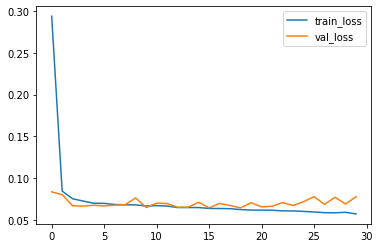

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
with open(f'./scalers/Karpos/PM10', 'rb') as f:
  scaler = pickle.load(f)

RMSE for LSTM prediction on PM10 concentration: 15.285
R2 score for LSTM prediction on PM10 concentration: 0.815


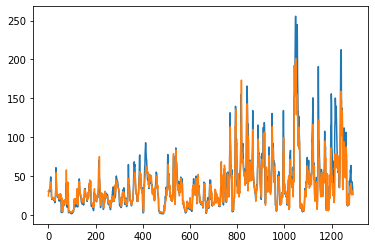

In [ ]:
y_predict_PM10 = model.predict(X_test_PM10, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM10)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM10)
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for LSTM prediction on PM10 concentration:", rmse)
print("R2 score for LSTM prediction on PM10 concentration:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

**GRU - PM10 prediction**

In [ ]:
model = create_GRU_model(num_of_steps, num_of_features)
csv_logger = CSVLogger("GRU_training_PM10.csv")
history = model.fit(X_train_PM10, y_train_PM10, epochs=30, 
                    validation_data=(X_validation_PM10, y_validation_PM10), verbose=1, callbacks=[csv_logger])

Epoch 1/30
329/329 [==============================] - 10s 22ms/step - loss: 0.3679 - val_loss: 0.0800
Epoch 2/30
329/329 [==============================] - 7s 21ms/step - loss: 0.0730 - val_loss: 0.0663
Epoch 3/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0692 - val_loss: 0.0653
Epoch 4/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0740 - val_loss: 0.0633
Epoch 5/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0702 - val_loss: 0.0623
Epoch 6/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0707 - val_loss: 0.0720
Epoch 7/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0672 - val_loss: 0.0726
Epoch 8/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0661 - val_loss: 0.0809
Epoch 9/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0656 - val_loss: 0.0641
Epoch 10/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0636 - val_l

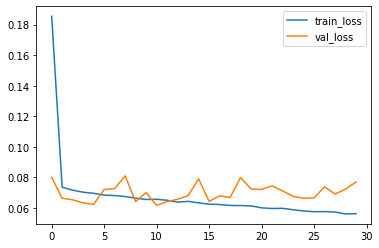

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

RMSE for GRU prediction on PM10 concentration: 12.884
R2 score for GRU prediction on PM10 concentration: 0.869


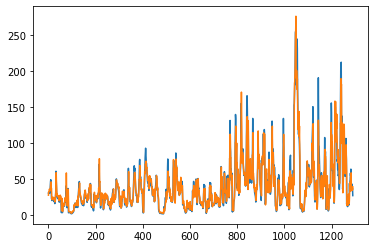

In [ ]:
y_predict_PM10 = model.predict(X_test_PM10, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM10)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM10)
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for GRU prediction on PM10 concentration:", rmse)
print("R2 score for GRU prediction on PM10 concentration:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

**LSTM - PM10 prediction - multi-step model for predicting several hours ahead**

In [ ]:
n_steps_in, n_steps_out = 24, 6
X_train_PM10, y_train_PM10 = split_multi_sequence(seq_train_PM10, n_steps_in, n_steps_out)
X_validation_PM10, y_validation_PM10 = split_multi_sequence(seq_validation_PM10, n_steps_in, n_steps_out)
X_test_PM10, y_test_PM10 = split_multi_sequence(seq_test_PM10, n_steps_in, n_steps_out)

X_train_PM10 = X_train_PM10.reshape((X_train_PM10.shape[0], X_train_PM10.shape[1], num_of_features))
X_validation_PM10 = X_validation_PM10.reshape((X_validation_PM10.shape[0], X_validation_PM10.shape[1], num_of_features))
X_test_PM10 = X_test_PM10.reshape((X_test_PM10.shape[0], X_test_PM10.shape[1], num_of_features))

In [ ]:
model = create_multi_step_LSTM_model(n_steps_in, n_steps_out, num_of_features)
csv_logger = CSVLogger("LSTM_multi_step_training_PM10.csv")
history = model.fit(X_train_PM10, y_train_PM10, epochs=10, 
                    validation_data=(X_validation_PM10, y_validation_PM10), verbose=1, callbacks=[csv_logger])

Epoch 1/10
329/329 [==============================] - 11s 28ms/step - loss: 0.5721 - val_loss: 0.2330
Epoch 2/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2557 - val_loss: 0.2200
Epoch 3/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2269 - val_loss: 0.2256
Epoch 4/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2013 - val_loss: 0.2156
Epoch 5/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1919 - val_loss: 0.2207
Epoch 6/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1809 - val_loss: 0.2264
Epoch 7/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1735 - val_loss: 0.2358
Epoch 8/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1556 - val_loss: 0.2548
Epoch 9/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1466 - val_loss: 0.2321
Epoch 10/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1315 - val_l

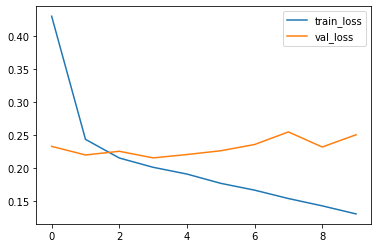

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

RMSE for LSTM prediction on PM10 concentration 6 hours ahead: 23.749
R2 score for LSTM prediction on PM10 concentration 6 hours ahead: 0.556


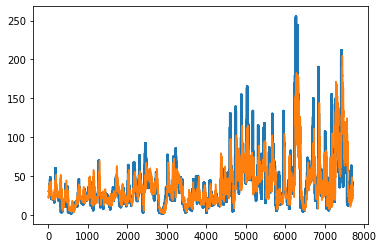

In [ ]:
y_predict_PM10 = model.predict(X_test_PM10, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM10)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM10)
y_true = y_true.flatten()
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for LSTM prediction on PM10 concentration 6 hours ahead:", rmse)
print("R2 score for LSTM prediction on PM10 concentration 6 hours ahead:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

**GRU - PM10 prediction - multi-step model for predicting several hours ahead**

In [ ]:
model = create_multi_step_GRU_model(n_steps_in, n_steps_out, num_of_features)
csv_logger = CSVLogger("GRU_multi_step_training_PM10.csv")
history = model.fit(X_train_PM10, y_train_PM10, epochs=10, 
                    validation_data=(X_validation_PM10, y_validation_PM10), verbose=1, callbacks=[csv_logger])

Epoch 1/10
329/329 [==============================] - 11s 27ms/step - loss: 0.4797 - val_loss: 0.2276
Epoch 2/10
329/329 [==============================] - 9s 27ms/step - loss: 0.2362 - val_loss: 0.2118
Epoch 3/10
329/329 [==============================] - 9s 27ms/step - loss: 0.2114 - val_loss: 0.2016
Epoch 4/10
329/329 [==============================] - 9s 27ms/step - loss: 0.2047 - val_loss: 0.2051
Epoch 5/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1950 - val_loss: 0.1960
Epoch 6/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1747 - val_loss: 0.2153
Epoch 7/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1731 - val_loss: 0.2011
Epoch 8/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1577 - val_loss: 0.2035
Epoch 9/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1512 - val_loss: 0.2165
Epoch 10/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1404 - val_l

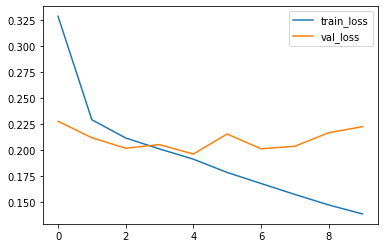

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

RMSE for GRU prediction on PM10 concentration 6 hours ahead: 23.849
R2 score for GRU prediction on PM10 concentration 6 hours ahead: 0.552


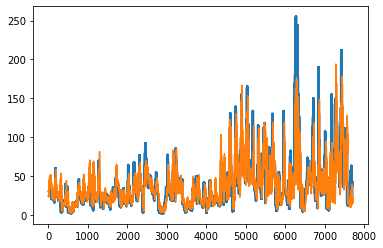

In [ ]:
y_predict_PM10 = model.predict(X_test_PM10, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM10)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM10)
y_true = y_true.flatten()
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for GRU prediction on PM10 concentration 6 hours ahead:", rmse)
print("R2 score for GRU prediction on PM10 concentration 6 hours ahead:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

**LSTM - PM25 prediction**


In [ ]:
df_train_PM25 = df_train.copy()
df_validation_PM25 = df_validation.copy()
df_test_PM25 = df_test.copy()
df_train_PM25.drop(['PM10', 'SO2'], axis=1, inplace=True)
df_validation_PM25.drop(['PM10', 'SO2'], axis=1, inplace=True)
df_test_PM25.drop(['PM10', 'SO2'], axis=1, inplace=True)

# 24 steps for 24 hours (1 day)
num_of_steps = 24
num_of_features = len(df_train_PM25.columns)

seq_train_PM25 = np.array(df_train_PM25)
seq_validation_PM25 = np.array(df_validation_PM25)
seq_test_PM25 = np.array(df_test_PM25)
X_train_PM25, y_train_PM25 = split_sequence(seq_train_PM25, num_of_steps)
X_validation_PM25, y_validation_PM25 = split_sequence(seq_validation_PM25, num_of_steps)
X_test_PM25, y_test_PM25 = split_sequence(seq_test_PM25, num_of_steps)

X_train_PM25 = X_train_PM25.reshape((X_train_PM25.shape[0], X_train_PM25.shape[1], num_of_features))
X_validation_PM25 = X_validation_PM25.reshape((X_validation_PM25.shape[0], X_validation_PM25.shape[1], num_of_features))
X_test_PM25 = X_test_PM25.reshape((X_test_PM25.shape[0], X_test_PM25.shape[1], num_of_features))

In [ ]:
model = create_LSTM_model(num_of_steps, num_of_features)
csv_logger = CSVLogger("LSTM_training_PM25.csv")
history = model.fit(X_train_PM25, y_train_PM25, epochs=30, 
                    validation_data=(X_validation_PM25, y_validation_PM25), verbose=1, callbacks=[csv_logger])

Epoch 1/30
329/329 [==============================] - 9s 21ms/step - loss: 0.3757 - val_loss: 0.0421
Epoch 2/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0963 - val_loss: 0.0303
Epoch 3/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0840 - val_loss: 0.0297
Epoch 4/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0880 - val_loss: 0.0250
Epoch 5/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0805 - val_loss: 0.0342
Epoch 6/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0851 - val_loss: 0.0275
Epoch 7/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0816 - val_loss: 0.0259
Epoch 8/30
329/329 [==============================] - 7s 20ms/step - loss: 0.0731 - val_loss: 0.0304
Epoch 9/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0789 - val_loss: 0.0231
Epoch 10/30
329/329 [==============================] - 6s 20ms/step - loss: 0.0752 - val_lo

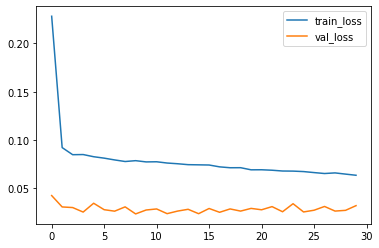

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
with open(f'./scalers/Karpos/PM25', 'rb') as f:
  scaler = pickle.load(f)

RMSE for LSTM prediction on PM25 concentration: 7.324
R2 score for LSTM prediction on PM25 concentration: 0.871


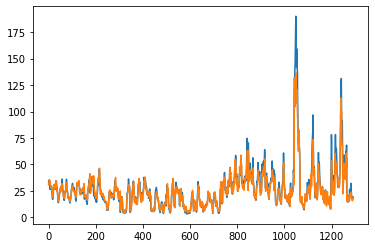

In [ ]:
y_predict_PM25 = model.predict(X_test_PM25, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM25)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM25)
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for LSTM prediction on PM25 concentration:", rmse)
print("R2 score for LSTM prediction on PM25 concentration:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

**GRU - PM25 prediction**

In [ ]:
model = create_GRU_model(num_of_steps, num_of_features)
csv_logger = CSVLogger("GRU_training_PM25.csv")
history = model.fit(X_train_PM25, y_train_PM25, epochs=30, 
                    validation_data=(X_validation_PM25, y_validation_PM25), verbose=1, callbacks=[csv_logger])

Epoch 1/30
329/329 [==============================] - 9s 22ms/step - loss: 0.4125 - val_loss: 0.0288
Epoch 2/30
329/329 [==============================] - 7s 21ms/step - loss: 0.0907 - val_loss: 0.0326
Epoch 3/30
329/329 [==============================] - 7s 21ms/step - loss: 0.0837 - val_loss: 0.0253
Epoch 4/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0811 - val_loss: 0.0253
Epoch 5/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0790 - val_loss: 0.0267
Epoch 6/30
329/329 [==============================] - 7s 21ms/step - loss: 0.0810 - val_loss: 0.0258
Epoch 7/30
329/329 [==============================] - 7s 21ms/step - loss: 0.0799 - val_loss: 0.0301
Epoch 8/30
329/329 [==============================] - 7s 21ms/step - loss: 0.0841 - val_loss: 0.0303
Epoch 9/30
329/329 [==============================] - 7s 21ms/step - loss: 0.0742 - val_loss: 0.0263
Epoch 10/30
329/329 [==============================] - 7s 22ms/step - loss: 0.0793 - val_lo

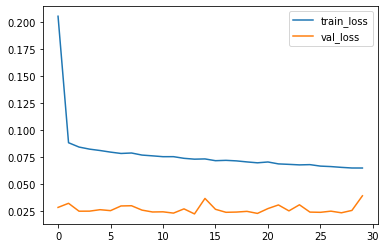

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

RMSE for GRU prediction on PM25 concentration: 6.501
R2 score for GRU prediction on PM25 concentration: 0.898


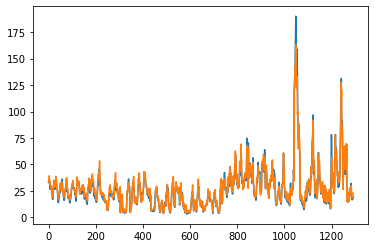

In [ ]:
y_predict_PM25 = model.predict(X_test_PM25, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM25)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM25)
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for GRU prediction on PM25 concentration:", rmse)
print("R2 score for GRU prediction on PM25 concentration:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

**LSTM - PM25 prediction - multi-step model for predicting several hours ahead**

In [ ]:
n_steps_in, n_steps_out = 24, 6
X_train_PM25, y_train_PM25 = split_multi_sequence(seq_train_PM25, n_steps_in, n_steps_out)
X_validation_PM25, y_validation_PM25 = split_multi_sequence(seq_validation_PM25, n_steps_in, n_steps_out)
X_test_PM25, y_test_PM25 = split_multi_sequence(seq_test_PM25, n_steps_in, n_steps_out)

X_train_PM25 = X_train_PM25.reshape((X_train_PM25.shape[0], X_train_PM25.shape[1], num_of_features))
X_validation_PM25 = X_validation_PM25.reshape((X_validation_PM25.shape[0], X_validation_PM25.shape[1], num_of_features))
X_test_PM25 = X_test_PM25.reshape((X_test_PM25.shape[0], X_test_PM25.shape[1], num_of_features))

In [ ]:
model = create_multi_step_LSTM_model(n_steps_in, n_steps_out, num_of_features)
csv_logger = CSVLogger("LSTM_multi_step_training_PM25.csv")
history = model.fit(X_train_PM25, y_train_PM25, epochs=10, 
                    validation_data=(X_validation_PM25, y_validation_PM25), verbose=1, callbacks=[csv_logger])

Epoch 1/10
329/329 [==============================] - 11s 28ms/step - loss: 0.6210 - val_loss: 0.1423
Epoch 2/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2824 - val_loss: 0.1481
Epoch 3/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2370 - val_loss: 0.1471
Epoch 4/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2211 - val_loss: 0.1143
Epoch 5/10
329/329 [==============================] - 9s 29ms/step - loss: 0.2177 - val_loss: 0.1067
Epoch 6/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2042 - val_loss: 0.1095
Epoch 7/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1882 - val_loss: 0.1351
Epoch 8/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1642 - val_loss: 0.1291
Epoch 9/10
329/329 [==============================] - 9s 27ms/step - loss: 0.1576 - val_loss: 0.1360
Epoch 10/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1487 - val_l

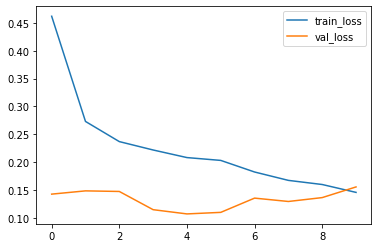

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

RMSE for LSTM prediction on PM25 concentration 6 hours ahead: 15.737
R2 score for LSTM prediction on PM25 concentration 6 hours ahead: 0.407


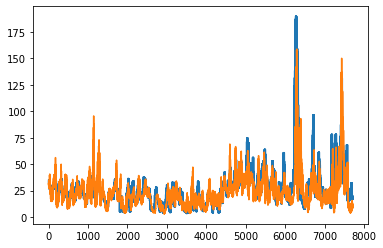

In [ ]:
y_predict_PM25 = model.predict(X_test_PM25, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM25)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM25)
y_true = y_true.flatten()
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for LSTM prediction on PM25 concentration 6 hours ahead:", rmse)
print("R2 score for LSTM prediction on PM25 concentration 6 hours ahead:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()

**GRU - PM25 prediction - multi-step model for predicting several hours ahead**

In [ ]:
model = create_multi_step_GRU_model(n_steps_in, n_steps_out, num_of_features)
csv_logger = CSVLogger("GRU_multi_step_training_PM25.csv")
history = model.fit(X_train_PM25, y_train_PM25, epochs=10, 
                    validation_data=(X_validation_PM25, y_validation_PM25), verbose=1, callbacks=[csv_logger])

Epoch 1/10
329/329 [==============================] - 12s 28ms/step - loss: 0.4818 - val_loss: 0.1166
Epoch 2/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2610 - val_loss: 0.1178
Epoch 3/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2589 - val_loss: 0.1069
Epoch 4/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2202 - val_loss: 0.1135
Epoch 5/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2193 - val_loss: 0.1021
Epoch 6/10
329/329 [==============================] - 9s 28ms/step - loss: 0.2030 - val_loss: 0.1262
Epoch 7/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1909 - val_loss: 0.1306
Epoch 8/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1957 - val_loss: 0.1078
Epoch 9/10
329/329 [==============================] - 9s 29ms/step - loss: 0.1758 - val_loss: 0.1092
Epoch 10/10
329/329 [==============================] - 9s 28ms/step - loss: 0.1670 - val_l

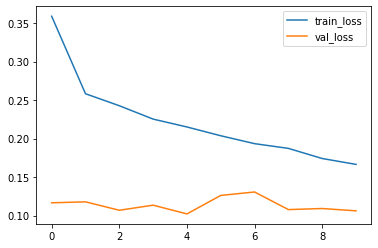

In [ ]:
plt.subplot()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

RMSE for GRU prediction on PM10 concentration 6 hours ahead: 14.228
R2 score for GRU prediction on PM10 concentration 6 hours ahead: 0.515


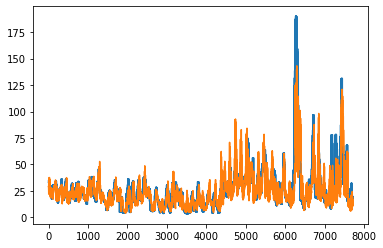

In [ ]:
y_predict_PM25 = model.predict(X_test_PM25, verbose=0)
y_pred = retransform_data(scaler, y_predict_PM25)
y_pred = y_pred.flatten()
y_true = retransform_data(scaler, y_test_PM25)
y_true = y_true.flatten()
rmse = round(float(np.sqrt(K.eval(tf.keras.losses.mean_squared_error(y_true, y_pred)))), 3)
r2 = round(r2_score(y_true, y_pred), 3)
print("RMSE for GRU prediction on PM10 concentration 6 hours ahead:", rmse)
print("R2 score for GRU prediction on PM10 concentration 6 hours ahead:", r2)
plt.plot(y_true)
plt.plot(y_pred)
plt.show()